In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from skimage.transform import resize
from skimage.io import imread, imsave

In [2]:
trainLabels = pd.read_csv('trainLabels.csv')
trainLabels.head(5)

,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R


In [3]:
def plot_sample(x, axis, title):
    # img = x.reshape(96,96)
    axis.imshow(x, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

def draw_multi_plot(X, row_num=4, col_num=4, fig_size=(15,10)):
    fig, axes = plt.subplots(nrows=row_num, ncols=col_num, figsize=fig_size)
    i=0
    for row in axes:
        for each_ax in row:
            plot_sample(X[i], each_ax, i)
            i += 1
    plt.tight_layout()

In [4]:
trainX = []
trainY_array = []
trainFiles = glob.glob("myTrainResized/*")
for i, nameFile in enumerate(trainFiles):
    # print(nameFile)
    id_col = int(nameFile.split('/')[-1].split('.')[0])
    trainY_array.append(trainLabels[trainLabels['ID'] == id_col]['Class'].item())
    image = imread(nameFile)
    trainX.append(image)
trainX = np.array(trainX)
print("trainX.shape", trainX.shape)
trainY = np.array(trainY_array)
trainY = pd.get_dummies(trainY).values
print("trainY.shape", trainY.shape)

trainX.shape (6283, 20, 20, 3)
trainY.shape (6283, 62)


In [13]:
class_size = trainY.shape[1]
class_size

62

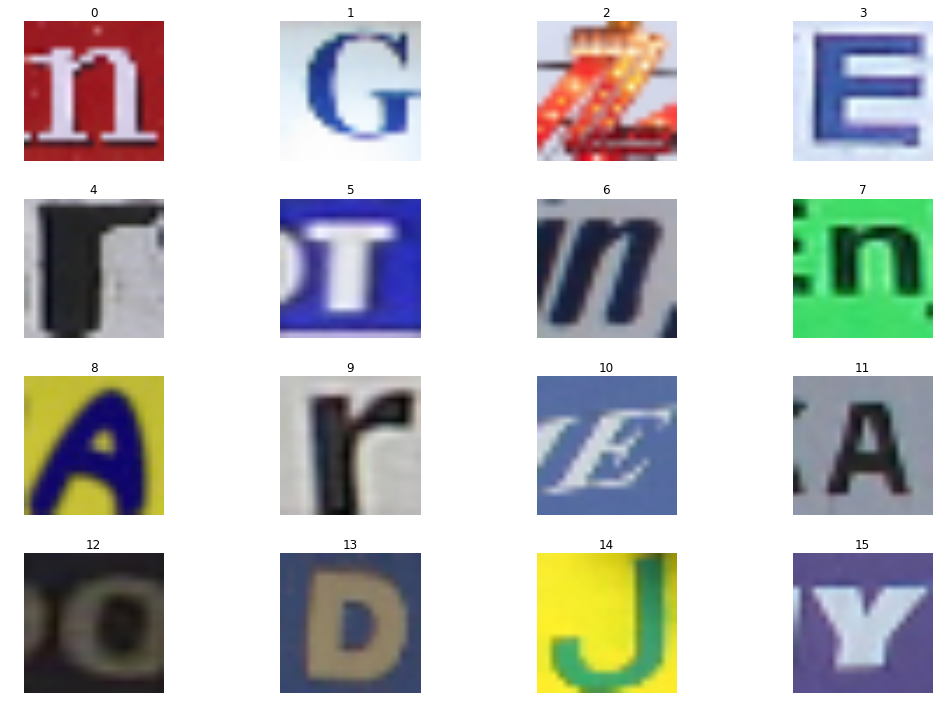

In [5]:
draw_multi_plot(trainX)

In [6]:
trainY_array[0:16]

['n',
 'G',
 'Z',
 'E',
 'r',
 'T',
 'n',
 'n',
 'A',
 'r',
 'E',
 'A',
 '0',
 'D',
 'J',
 'Y']

### 라벨링 재정의 된듯 하다!

In [7]:
from keras.backend import image_dim_ordering
image_dim_ordering()

Using TensorFlow backend.


'tf'

In [10]:
def make_config(img_row, img_col, filter_size=3, epoch=1, batch_size=128, layer_filter1=32, layer_filter2=64, layer_filter3=128):
    config_dict = {
        "epoch":epoch,
        "batch_size":batch_size,
        "img_row":img_row,
        "img_col":img_col,
        "filter_size":filter_size,
        "filter1":layer_filter1,
        "filter2":layer_filter2,
        "filter3":layer_filter3,
    }
    return config_dict

In [11]:
config = make_config(20, 20, layer_filter1=64, layer_filter2=128)
config

{'batch_size': 128,
 'epoch': 1,
 'filter1': 64,
 'filter2': 128,
 'filter3': 128,
 'filter_size': 3,
 'img_col': 20,
 'img_row': 20}

In [8]:
import keras.models as kmodel
import keras.layers.convolutional as conv
import keras.layers.core as core

In [14]:
cnn1 = kmodel.Sequential()
cnn1.add(conv.Convolution2D(config['filter1'], config['filter_size'], config['filter_size'], 
                            activation='relu', input_shape=(config['img_row'], config['img_col'], 3), border_mode='same'))
cnn1.add(conv.Convolution2D(config['filter1'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))
cnn1.add(conv.MaxPooling2D(strides=(2,2))) # 2*2칸중 가장 큰 값으로 정한다

# L2
cnn1.add(conv.Convolution2D(config['filter2'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))
cnn1.add(conv.Convolution2D(config['filter2'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))
cnn1.add(conv.MaxPooling2D(strides=(2,2)))

cnn1.add(core.Flatten()) # 내용물을 1차원으로 쭉 피는 역할을 한다
cnn1.add(core.Dense(500, activation='relu')) # Fully Connected Layer. 뉴런의 갯수는 500로 한다.
cnn1.add(core.Dense(class_size, activation='softmax')) # Fully Connected Softmax 로 마지막에 클래스별 확률값을 구해낸다.
cnn1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 20, 20, 64)    1792        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 20, 20, 64)    36928       convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 10, 10, 64)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 10, 10, 128)   73856       maxpooling2d_3[0][0]             
___________________________________________________________________________________________

In [15]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn1

In [17]:
cnn1.fit(trainX, trainY, batch_size=config['batch_size'], nb_epoch=10, verbose=1)

Epoch 1/10
6283/6283 [==============================] - 50s - loss: 1.8630 - acc: 0.5160    
Epoch 2/10
6283/6283 [==============================] - 49s - loss: 1.5210 - acc: 0.5980    
Epoch 3/10
6283/6283 [==============================] - 50s - loss: 1.2560 - acc: 0.6554    
Epoch 4/10
6283/6283 [==============================] - 52s - loss: 1.0008 - acc: 0.7156    
Epoch 5/10
6283/6283 [==============================] - 52s - loss: 0.8771 - acc: 0.7441    
Epoch 6/10
6283/6283 [==============================] - 52s - loss: 0.7315 - acc: 0.7850    
Epoch 7/10
6283/6283 [==============================] - 52s - loss: 0.5792 - acc: 0.8240    
Epoch 8/10
6283/6283 [==============================] - 52s - loss: 0.4742 - acc: 0.8556    
Epoch 9/10
6283/6283 [==============================] - 51s - loss: 0.3972 - acc: 0.8676    
Epoch 10/10
6283/6283 [==============================] - 50s - loss: 0.3119 - acc: 0.9023    


In [18]:
from keras.models import save_model

In [21]:
cnn1.save_weights('./JuliaByKeras-exp2.h5')

ImportError: No module named 'h5py'